In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns

import os

from tqdm import tqdm

In [2]:
DATASET_ROOT_PATH = "/home/alex/MThesis/datasets/VISDRONE/Images"
TRAIN_DATA_ANNOTATIONS = "/VisDrone2018-DET-train/annotations"
TEST_DATA_ANNOTATIONS  = "/VisDrone2018-DET-val/annotations" 

TRAIN_DATA_IMAGES = "/VisDrone2018-DET-train/images"
TEST_DATA_IMAGES  = "/VisDrone2018-DET-val/images" 

TEST_DIRECTORY = DATASET_ROOT_PATH + TEST_DATA_ANNOTATIONS
TRAIN_DIRECTORY = DATASET_ROOT_PATH + TRAIN_DATA_ANNOTATIONS

TEST_DIRECTORY_IMAGES = DATASET_ROOT_PATH + TEST_DATA_IMAGES
TRAIN_DIRECTORY_IMAGES = DATASET_ROOT_PATH + TRAIN_DATA_IMAGES

categories_names = ['Ignored Regions', 'Pedestrian', 'People', 'Bicycle', 'Car', 'Van', 'Truck', 'Tricycle', 'Awning-tricycle', 'Bus', 'Motorbike', 'Other']


In [3]:
col = ['IMG_IDX', 'bbox_left', 'bbox_top', 'bbox_width', 'bbox_height', 'score', 'cat', 'file']
df = pd.DataFrame(columns=col)

BACKUP_FILE_PATH = TEST_DIRECTORY+'/filedata.csv'

if os.path.isfile(BACKUP_FILE_PATH):
    df = pd.read_csv(BACKUP_FILE_PATH)
else:

    img_index = 0
    filenames = [ x for x in os.listdir(directory) if x.endswith('.txt')]
    for filename in tqdm(filenames, desc="Reading files"):
        f = open(directory + '/' + filename)
        lines = f.readlines()

        for line in lines:
            data = line.split(',')
            df1 = pd.DataFrame([[img_index, int(data[0]), int(data[1]), int(data[2]), int(data[3]), int(data[4]), int(data[5]), filename]], columns=col)
            df = df.append(df1)

            if data[5] == 11:
                print (filename)
        img_index = img_index + 1
        continue
        
    df.to_csv(BACKUP_FILE_PATH, index=False, header=False)

NameError: name 'directory' is not defined

In [ ]:
df2 = df.loc[df['cat'] == 1]
# df2 = df2.loc[df2['bbox_width'] < 5]

grouped = [g for _, g in df2.groupby(['IMG_IDX'])]
print (len(grouped))


In [ ]:
imgDf = grouped[1]

# filename is the same
filename = imgDf.iloc[0, 7]
print (filename)

filename = filename.split('.')[0]
imgPath = TEST_DIRECTORY_IMAGES + '/' + filename + '.jpg'
im = np.array(Image.open(imgPath), dtype=np.uint8)

# Create figure and axes
fig,ax = plt.subplots(1)
fig.set_size_inches(30.5, 25.5)

# Display the image
ax.imshow(im)

for table_idx, row in imgDf.iterrows():

    bbox_left = row[1]
    bbox_top = row[2]
    bbox_width = row[3]
    bbox_height = row[4]
    
    # Create a Rectangle patch
    rect = patches.Rectangle((bbox_left,bbox_top),bbox_width,bbox_height,linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()


In [ ]:
# dataset statistics 

df3 = df

df3['resolution'] = df3['bbox_width'] * df3['bbox_height']

# print(df3)

categories = [g for _, g in df3.groupby(['cat'])]

for idx, category in enumerate(categories): 
    print ("category")
    print (categories_names[idx])
     
    print ("width:", round(category['bbox_width'].mean(axis=0),2), "dev:", round(category['bbox_width'].std(),2), "min:", category['bbox_width'].min(), "max:", category['bbox_width'].max())
    print ("height:", round(category['bbox_height'].mean(axis=0),2), "dev:", round(category['bbox_height'].std(),2), "min:", category['bbox_height'].min(), "max:", category['bbox_height'].max())
    
    resolutions = category['resolution'].values
    print(resolutions)
    
    print ("\n")

In [4]:
import os
import json

In [5]:
def addCatItem(name, category_item_id):

    category_item = dict()
    category_item['supercategory'] = 'none'

    category_item['id'] = category_item_id
    category_item['name'] = name
    coco['categories'].append(category_item)
    category_set[name] = category_item_id


def addImgItem(file_name, size):
    global image_id
    if file_name is None:
        raise Exception('Could not find filename tag in xml file.')
    if size['width'] is None:
        raise Exception('Could not find width tag in xml file.')
    if size['height'] is None:
        raise Exception('Could not find height tag in xml file.')
    image_id += 1
    image_item = dict()
    image_item['id'] = image_id
    image_item['file_name'] = file_name
    image_item['width'] = size['width']
    image_item['height'] = size['height']
    coco['images'].append(image_item)
    image_set.add(file_name)
    return image_id

def addAnnoItem(object_name, image_id, category_id, bbox, score):
    global annotation_id
    annotation_item = dict()
    annotation_item['segmentation'] = []
    seg = []
    #bbox[] is x,y,w,h
    #left_top
    seg.append(bbox[0])
    seg.append(bbox[1])
    #left_bottom
    seg.append(bbox[0])
    seg.append(bbox[1] + bbox[3])
    #right_bottom
    seg.append(bbox[0] + bbox[2])
    seg.append(bbox[1] + bbox[3])
    #right_top
    seg.append(bbox[0] + bbox[2])
    seg.append(bbox[1])

    annotation_item['segmentation'].append(seg)

    annotation_item['area'] = bbox[2] * bbox[3]
    annotation_item['iscrowd'] = 0
    annotation_item['ignore'] = 0
    annotation_item['image_id'] = image_id
    annotation_item['bbox'] = bbox
    annotation_item['category_id'] = category_id
    annotation_item['score'] = score
    annotation_id += 1
    annotation_item['id'] = annotation_id
    coco['annotations'].append(annotation_item)

def parseFiles(directory, img_directory): 

    filenames = [ x for x in os.listdir(directory) if x.endswith('.txt')]    
    bndbox = dict()
    
    for filename in tqdm(filenames, desc="Reading files"):
        f = open(directory + '/' + filename)
        lines = f.readlines()
        
        current_image_id = None
        current_category_id = None
        size = dict()
        size['width'] = None
        size['height'] = None
        
        img_filename = filename.split('.')[0]
        img_filename = img_filename + '.jpg'
        imgPath = img_directory + '/' + img_filename 
        
        img = Image.open(imgPath)
        size['width'], size['height'] = img.size
        
        if current_image_id is None and img_filename is not None and size['width'] is not None:
            if filename not in image_set:
                current_image_id = addImgItem(img_filename, size)
#                 print('add image with {} and {}'.format(filename, size))
            else:
                raise Exception('duplicated image: {}'.format(filename))
        

        for line in lines:
            data = line.split(',')
            score = int(data[4])
            current_category_id = int(data[5])
            object_name = categories_names[current_category_id]
            
            if object_name not in category_set:
                addCatItem(object_name, current_category_id)

            bbox = []
            #x
            bbox.append(int(data[0]))
            #y
            bbox.append(int(data[1]))
            #w
            bbox.append(int(data[2]))
            #h
            bbox.append(int(data[3]))
            
            
#             print('add annotation with {},{},{},{}'.format(object_name, current_image_id, current_category_id, bbox))
            addAnnoItem(object_name, current_image_id, current_category_id, bbox, score)


In [6]:
coco = dict()
coco['images'] = []
coco['type'] = 'instances'
coco['annotations'] = []
coco['categories'] = []

category_set = dict()
image_set = set()

category_item_id = 0
image_id = 20180000000
annotation_id = 0


directory = TRAIN_DIRECTORY
img_directory = TRAIN_DIRECTORY_IMAGES

print("Parsing file from {}".format(TEST_DIRECTORY))

json_file = 'instances.json'
parseFiles(directory, img_directory)

# json.dump(coco, open(directory + '/' + json_file, 'w'), indent=0)
# print ("JSON Dumped")

Reading files:   0%|          | 0/6471 [00:00<?, ?it/s]

Parsing file from /home/alex/MThesis/datasets/VISDRONE/Images/VisDrone2018-DET-val/annotations


Reading files: 100%|██████████| 6471/6471 [01:38<00:00, 65.65it/s] 


In [6]:
# extract the test annotations (manual)
df_annotations_test = pd.DataFrame.from_dict(coco['annotations'])
df_images_test      = pd.DataFrame.from_dict(coco['images'])
df_images_test['resolution'] = df_images_test['width'] * df_images_test['height']

In [7]:
# extract the train annotations (manual)
df_annotations_train = pd.DataFrame.from_dict(coco['annotations'])
df_images_train      = pd.DataFrame.from_dict(coco['images'])
df_images_train['resolution'] = df_images_train['width'] * df_images_train['height']

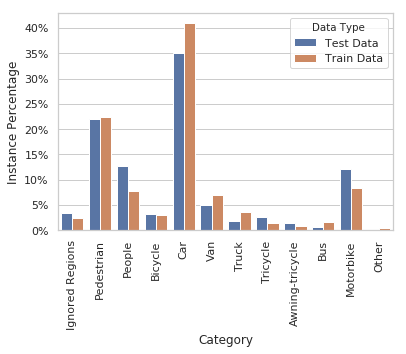

In [12]:
# percentage of categories in total / train vs test 
df_test = df_annotations_test['category_id'].value_counts()
df_train = df_annotations_train['category_id'].value_counts()

result1 = pd.DataFrame(columns=['Category', 'Data Type', 'Instance Percentage'])
result2 = pd.DataFrame(columns=['Category', 'Data Type', 'Instance Percentage'])

df_test = df_test.sort_index()
df_train = df_train.sort_index()

# categories are already sorted
result1['Category'] = categories_names
result2['Category'] = categories_names

result1['Data Type'] = 'Test Data'
result2['Data Type'] = 'Train Data'

result1['Instance Percentage'] = df_test.values / np.sum(df_test.values)
result2['Instance Percentage'] = df_train.values/ np.sum(df_train.values)

result = pd.concat([result1, result2])



sns.set(style="whitegrid")
g = sns.barplot(x="Category", y="Instance Percentage", hue="Data Type", data=result)

g.set_xticklabels(g.get_xticklabels(), rotation=90)
vals = g.get_yticks()
g.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

plt.savefig("instances_per_category.jpg", type="jpg",dpi=400,bbox_inches='tight')

In [224]:
# create val images 
val_images = []

img_directory = DATASET_ROOT_PATH + "/VisDrone2018-DET-test-challenge/images" 
filenames = [ x for x in os.listdir(img_directory) if x.endswith('.jpg')]

for filename in tqdm(filenames, desc="Reading files"):

    imgPath = img_directory + '/' + filename
    img = Image.open(imgPath)
    width, height = img.size
    
    image_item = dict()
    image_item['file_name'] = filename
    image_item['width'] = width
    image_item['height'] = height
    
    val_images.append(image_item)
    
df_images_val = pd.DataFrame.from_dict(val_images)

Reading files: 100%|██████████| 1580/1580 [00:00<00:00, 3949.36it/s]


In [223]:
# Image resolution distribution

df_img_test   = df_images_test.groupby(['width','height']).count()
df_img_train  = df_images_train.groupby(['width','height']).count()
df_img_val    = df_images_val.groupby(['width','height']).count()

print(df_images_test.shape)
print(df_img_test)

print(df_images_train.shape)
print(df_img_train)

print(df_images_val.shape)
print(df_img_val)

(548, 5)
              file_name   id  resolution
width height                            
960   540           121  121         121
1360  765           408  408         408
1920  1080           19   19          19
(6471, 5)
              file_name    id  resolution
width height                             
480   360             1     1           1
960   540           250   250         250
1344  756             1     1           1
1360  765           743   743         743
1389  1042            1     1           1
1398  1048           30    30          30
1400  788          1299  1299        1299
      1050         2498  2498        2498
1916  1078          537   537         537
1920  1080          339   339         339
2000  1500          772   772         772
(1580, 3)
              file_name
width height           
960   540            64
1360  765           150
1400  788           712
      1050          491
1916  1078          127
1920  1080           36


341
914
20180000448
20180000032
447    0000295_02000_d_0000031.txt
Name: file_name, dtype: object
31    0000059_01886_d_0000114.txt
Name: file_name, dtype: object


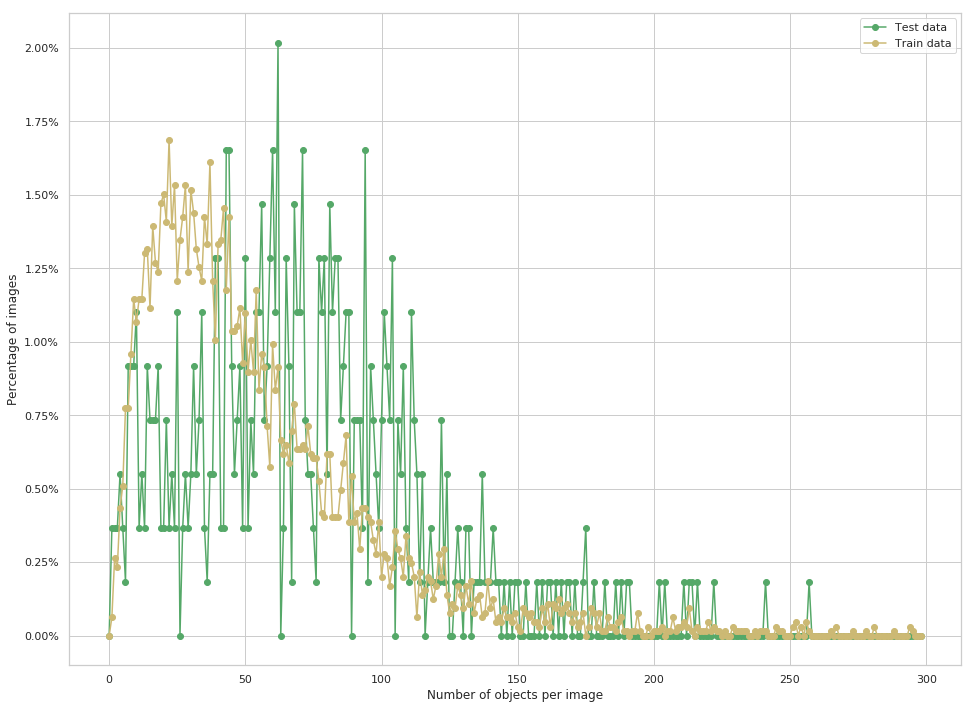

In [369]:
# max number of objects per image + number of objects per image
df_test  = df_annotations_test.groupby(['image_id']).count()
df_train = df_annotations_train.groupby(['image_id']).count()

max_test  = df_test['id'].max()
max_train = df_train['id'].max()

print(max_test)
print(max_train)

test_index = df_test[df_test['id']==max_test].index
train_index = df_train[df_train['id']==max_train].index

print(test_index[0])
print(train_index[0])

print(df_images_test[df_images_test['id'] == test_index[0]]['file_name'])
print(df_images_train[df_images_train['id'] == train_index[0]]['file_name'])

no_objects_test = df_annotations_test.groupby(['image_id']).count()['area'].values
no_objects_train = df_annotations_train.groupby(['image_id']).count()['area'].values


hist_test = np.histogram(no_objects_test, bins=np.arange(300), density=True)
hist_train = np.histogram(no_objects_train, bins=np.arange(300), density=True)
# print(hist_test)
# print(hist_train)

plt.figure(figsize = (16,12))

plt.plot(np.arange(299),hist_test[0], 'go-' ,label='Test data')
plt.plot(np.arange(299),hist_train[0], 'yo-', label='Train data')
plt.legend()

plt.ylabel('Percentage of images')
plt.xlabel('Number of objects per image')

ax = plt.gca()
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])



plt.savefig("number_of_objects.jpg", type="jpg",dpi=400,bbox_inches='tight')
plt.show()


In [15]:
# size of the object relative to the image size 
df_test = df_annotations_test 
df_test['bbox_size'] = [bbox[2]*bbox[3] for bbox in df_test['bbox']]
df_test_img_lookup = df_images_test[['id', 'resolution']]
df_test_img_lookup = df_test_img_lookup.set_index('id')
df_test['im_resolution'] = [df_test_img_lookup.loc[id].values[0] for id in df_test['image_id'].values]

sizes_test = np.array(df_test['bbox_size'].values, dtype=float)
bbox_test = sizes_test
res = df_test['im_resolution'].values


for i in range(len(sizes_test)):
    sizes_test[i] = sizes_test[i]/res[i]
    
print("mean test : ", np.mean(sizes_test)) 

df_train = df_annotations_train
df_train['bbox_size'] = [bbox[2]*bbox[3] for bbox in df_train['bbox']]
df_train_img_lookup = df_images_train[['id', 'resolution']]
df_train_img_lookup = df_train_img_lookup.set_index('id')
df_train['im_resolution'] = [df_train_img_lookup.loc[id].values[0] for id in df_train['image_id'].values]

sizes_train = np.array(df_train['bbox_size'].values, dtype=float)
bbox_train = sizes_train
res = df_train['im_resolution'].values

for i in range(len(sizes_train)):
    sizes_train[i] = sizes_train[i]/res[i]
    
print("mean train : ", np.mean(sizes_train)) 


mean test :  0.0016331235690164778
mean train :  0.0015643464289976012


In [18]:
print("median test : ", np.median(sizes_test)) 
print("median train : ", np.median(sizes_train)) 

print(len(sizes_test)*0.1)
print(len(sizes_train)*0.1)

median test :  0.0005666473765432099
median train :  0.0004658564814814815
4016.9
35355.0


In [20]:
df_train_work = df_train
df_test_work = df_test

df_train_work = df_train_work.sort_values(by=['bbox_size'])
df_test_work = df_test_work.sort_values(by=['bbox_size'])

first_test  = df_train_work.head(4016)
first_train = df_test_work.head(35355)

last_test   = df_train_work.tail(4016)
last_train  = df_test_work.tail(35355)



In [27]:
sizes_test = np.array(last_test['bbox_size'].values, dtype=float)
res = last_test['im_resolution'].values

for i in range(len(sizes_test)):
    sizes_test[i] = sizes_test[i]/res[i]
    
sizes_train = np.array(last_train['bbox_size'].values, dtype=float)
res = first_train['im_resolution'].values

for i in range(len(last_train)):
    sizes_train[i] = sizes_train[i]/res[i]
    
print("mean test : ", np.mean(sizes_test))
print("mean train : ", np.mean(sizes_train))

mean test :  0.025670113284774046
mean train :  0.0019244847669806317


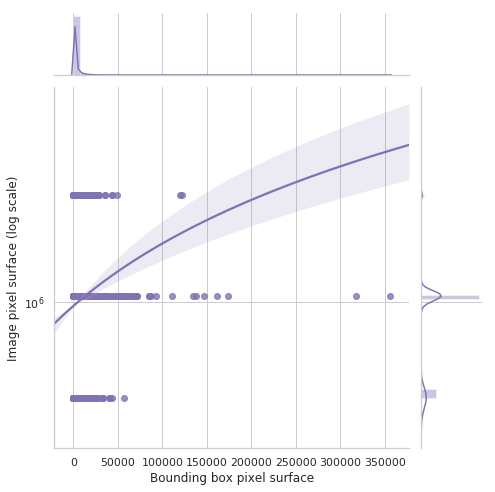

In [372]:
# sns.set(style="darkgrid")

g = sns.jointplot("bbox_size", "im_resolution", data=df_test, kind="reg", color="m", height=7)
# g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')
g.ax_joint.set(xlabel='Bounding box pixel surface', ylabel='Image pixel surface (log scale)')

plt.savefig("bounding_box_scales.jpg", type="jpg",dpi=400,bbox_inches='tight')


In [310]:
# TODO: graficul din paper-ul original, cu distributia majoritara 

       area                 bbox  category_id     id  ignore     image_id  \
0      4968   [871, 572, 54, 92]            4      1       0  20180000001   
1      5704   [948, 592, 62, 92]            4      2       0  20180000001   
2      7370  [874, 705, 67, 110]            4      3       0  20180000001   
3      1458   [971, 791, 27, 54]           10      4       0  20180000001   
4       722   [976, 794, 19, 38]            2      5       0  20180000001   
5      2208   [414, 921, 48, 46]           10      6       0  20180000001   
6       702  [447, 1054, 27, 26]            1      7       0  20180000001   
7      1323   [430, 902, 27, 49]            1      8       0  20180000001   
8      2860   [405, 837, 55, 52]            8      9       0  20180000001   
9       684   [416, 856, 19, 36]            2     10       0  20180000001   
10     3660   [349, 796, 60, 61]            8     11       0  20180000001   
11     1716   [378, 753, 39, 44]           10     12       0  20180000001   

      area               bbox  category_id    id  ignore     image_id  \
2396    30     [59, 88, 6, 5]            1  2397       0  20180000032   
2397    30     [63, 92, 6, 5]            1  2398       0  20180000032   
2398    28     [66, 90, 7, 4]            1  2399       0  20180000032   
2399    48     [62, 85, 8, 6]            1  2400       0  20180000032   
2400    50   [42, 147, 10, 5]            1  2401       0  20180000032   
2401    36    [31, 157, 9, 4]            1  2402       0  20180000032   
2402    48    [29, 158, 8, 6]            1  2403       0  20180000032   
2403    36    [30, 152, 6, 6]            1  2404       0  20180000032   
2404    63    [53, 177, 9, 7]            1  2405       0  20180000032   
2405    30    [78, 169, 6, 5]            1  2406       0  20180000032   
2406    35    [76, 165, 7, 5]            1  2407       0  20180000032   
2407    24    [84, 153, 6, 4]            1  2408       0  20180000032   
2408    35    [95, 166, 7, 5]            1  2409   

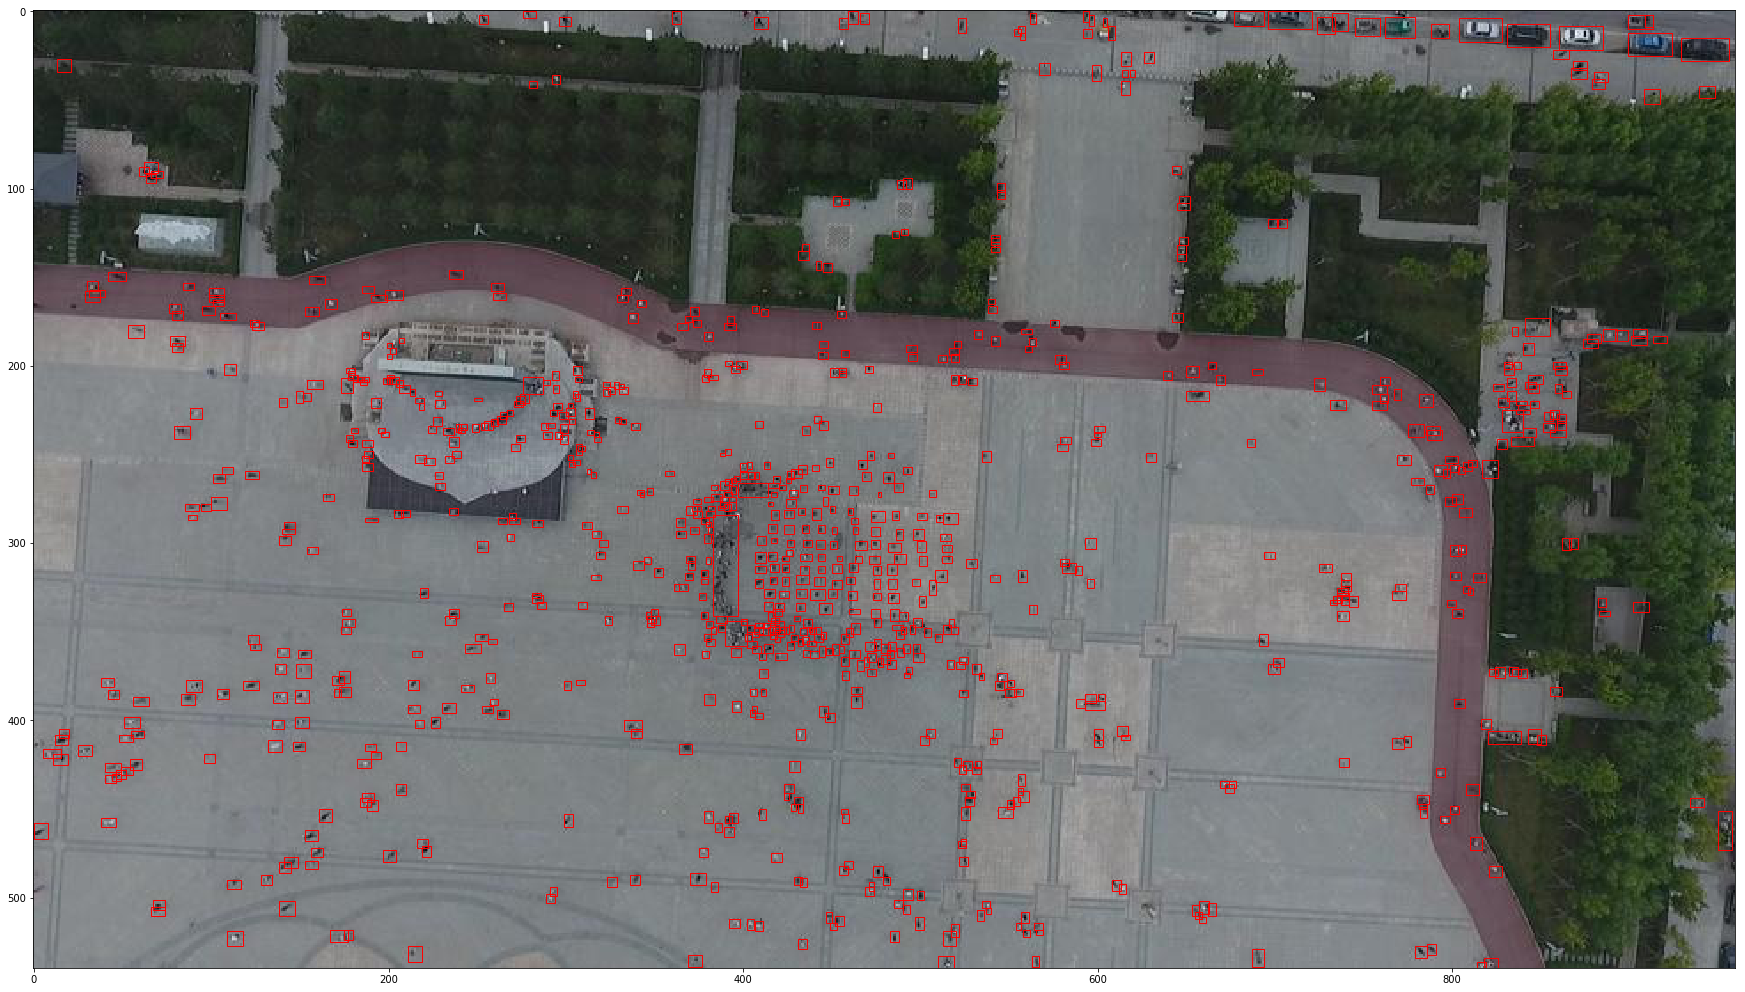

In [12]:
filename = '0000059_01886_d_0000114'
imgPath = TRAIN_DIRECTORY_IMAGES + '/' + filename + '.jpg'
im = np.array(Image.open(imgPath), dtype=np.uint8)

# Create figure and axes
fig,ax = plt.subplots(1)
fig.set_size_inches(30.5, 25.5)

# print(df_annotations_train)

imgDf = df_annotations_train[df_annotations_train['image_id']==20180000032]

print(imgDf)

# Display the image
ax.imshow(im)

for table_idx, row in imgDf.iterrows():

    bbox_left = row[1][0]
    bbox_top = row[1][1]
    bbox_width = row[1][2]
    bbox_height = row[1][3]
    
    # Create a Rectangle patch
    rect = patches.Rectangle((bbox_left,bbox_top),bbox_width,bbox_height,linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()
